In [1]:
import xarray as xr
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import argparse
import intake
from intake import open_catalog
from matplotlib import colors, cm, pyplot as plt

In [2]:
def advections(u_v_field: xr.Dataset, grid_data: xr.Dataset,typenum=0):
    dxu = grid_data['dxu']
    dyu = grid_data['dyu']
    gradient_x = u_v_field.diff(dim='xu_ocean') / dxu
    gradient_y = u_v_field.diff(dim='yu_ocean') / dyu
    # Interpolate back the gradients
    interp_coords = dict(xu_ocean=u_v_field.coords['xu_ocean'],
                         yu_ocean=u_v_field.coords['yu_ocean'])
    gradient_x = gradient_x.interp(interp_coords)
    gradient_y = gradient_y.interp(interp_coords)
    u, v = u_v_field['usurf'], u_v_field['vsurf']
    
    adv = u * gradient_x + v * gradient_y
    names=list(u_v_field.keys())
    
    adv_u = u * gradient_x['usurf'] + v * gradient_y['usurf']
    adv_v = u * gradient_x['vsurf'] + v * gradient_y['vsurf']
    adv_T = u * gradient_x['surface_temp'] + v * gradient_y['surface_temp']
    result = xr.Dataset({'Su': adv_u,'Sv': adv_v,'ST': adv_T })
    
    return result
def spatial_filter(data: np.ndarray, sigma: float):
    
    ndim=len(data.shape)
    #print(ndim)
    if ndim==3:
        result = np.zeros_like(data)
        for t in range(data.shape[0]):
            data_t = data[t, ...]
            result_t = gaussian_filter(data_t, sigma, mode='constant')
            result[t, ...] = result_t
    elif ndim==4:
        preshape=data.shape
        data=data.reshape([preshape[0]*preshape[1],preshape[2],preshape[3]])
        result = np.zeros(data.shape)
        for t in range(data.shape[0]):
            data_t = data[t, ...]
            result_t = gaussian_filter(data_t, sigma, mode='constant')
            result[t, ...] = result_t
        result=result.reshape([preshape[0],preshape[1],result.shape[1],result.shape[2]])
    return result

def spatial_filter_dataset(dataset: xr.Dataset, grid_info: xr.Dataset,
                           sigma: float):
    area_u = grid_info['dxu'] * grid_info['dyu'] / 1e8
    dataset = dataset * area_u
    # Normalisation term, so that if the quantity we filter is constant
    # over the domain, the filtered quantity is constant with the same value
    norm = xr.apply_ufunc(lambda x: gaussian_filter(x, sigma, mode='constant'),
                          area_u, dask='parallelized', output_dtypes=[float, ])
    filtered = xr.apply_ufunc(lambda x: spatial_filter(x, sigma), dataset,
                              dask='parallelized', output_dtypes=[float, ])
    return filtered / norm

def eddy_forcing(u_v_dataset : xr.Dataset, grid_data: xr.Dataset,
                 scale: int, method: str = 'mean',
                 nan_or_zero: str = 'zero', scale_mode: str = 'factor',
                 debug_mode=False,typenum=0) -> xr.Dataset:

    # Replace nan values with zeros.
    if nan_or_zero == 'zero':
        u_v_dataset = u_v_dataset.fillna(0.0)
    if scale_mode == 'factor':
        #print('Using factor mode')
        scale_x = scale
        scale_y = scale

    scale_filter = (scale_x / 2, scale_y / 2)
    # High res advection terms
    adv = advections(u_v_dataset, grid_data,typenum=typenum)
    # Filtered advections
    filtered_adv = spatial_filter_dataset(adv, grid_data, scale_filter)
    # Filtered u,v field and temperature
    u_v_filtered = spatial_filter_dataset(u_v_dataset, grid_data, scale_filter)
    # Advection term from filtered velocity field
    adv_filtered = advections(u_v_filtered, grid_data,typenum=typenum)
    # Forcing
    forcing = adv_filtered - filtered_adv
    #if typenum==0:
    #forcing = forcing.rename({'adv': 'S'})
    # Merge filtered u,v, temperature and forcing terms
    forcing = forcing.merge(u_v_filtered)
    # Coarsen
    #print('scale factor: ', scale)
    forcing_coarse = forcing.coarsen({'xu_ocean': int(scale_x),
                                      'yu_ocean': int(scale_y)},
                                     boundary='trim')
    if method == 'mean':
        forcing_coarse = forcing_coarse.mean()
    else:
        raise ValueError('Passed coarse-graining method not implemented.')
    if nan_or_zero == 'zero':
        # Replace zeros with nans for consistency
        forcing_coarse = forcing_coarse.where(forcing_coarse['usurf'] != 0)
    if not debug_mode:
        return forcing_coarse
    u_v_dataset = u_v_dataset.merge(adv)
    filtered_adv = filtered_adv.rename({'adv_x': 'f_adv_x',
                                        'adv_y': 'f_adv_y'})
    adv_filtered = adv_filtered.rename({'adv_x': 'adv_f_x',
                                        'adv_y': 'adv_f_y'})
    u_v_filtered = u_v_filtered.rename({'usurf': 'f_usurf',
                                        'vsurf': 'f_vsurf'})
    u_v_dataset = xr.merge((u_v_dataset, u_v_filtered, adv, filtered_adv,
                            adv_filtered, forcing[['S_x', 'S_y']]))
    return u_v_dataset, forcing_coarse

In [3]:
raw_data_address='/scratch/zanna/data/cm2.6/surf-data.zarr'

In [4]:
ls /scratch/zanna/data/cm2.6

1pct-CO2-3D-data.zarr/                    coarse-3D-data-sigma-16.zarr/
1pct-CO2-surf-data.zarr/                  coarse-3D-data-sigma-4.zarr/
1pct_co2/                                 coarse-3D-data-sigma-6.zarr/
3D-data.zarr/                             coarse-3D-data-sigma-8.zarr/
coarse-1pct-CO2-3D-data-sigma-12.zarr/    coarse-surf-data-sigma-10.zarr/
coarse-1pct-CO2-3D-data-sigma-16.zarr/    coarse-surf-data-sigma-12.zarr/
coarse-1pct-CO2-3D-data-sigma-4.zarr/     coarse-surf-data-sigma-14.zarr/
coarse-1pct-CO2-3D-data-sigma-8.zarr/     coarse-surf-data-sigma-16.zarr/
coarse-1pct-CO2-surf-data-sigma-12.zarr/  coarse-surf-data-sigma-4.zarr/
coarse-1pct-CO2-surf-data-sigma-16.zarr/  coarse-surf-data-sigma-6.zarr/
coarse-1pct-CO2-surf-data-sigma-4.zarr/   coarse-surf-data-sigma-8.zarr/
coarse-1pct-CO2-surf-data-sigma-8.zarr/   geometry/
coarse-3D-data-sigma-10.zarr/             info.txt*
coarse-3D-data-sigma-12.zarr/             picontrol/
coarse-3D-data-sigma-14.zarr/             s

In [60]:

xu=xr.open_zarr(raw_data_address)\
                    .chunk(chunks={"time":1}).isel(time=np.arange(TIME,TIME+1)).xu_ocean.values

In [61]:
xu

array([-279.9, -279.8, -279.7, ...,   79.8,   79.9,   80. ])

In [113]:


TIME=500

xmin=-60#-135
xmax=0#-100

ymin=30#-20
ymax=60#10



u_v_dataset=xr.open_zarr(raw_data_address)\
                    .chunk(chunks={"time":1}).isel(time=np.arange(TIME,TIME+1))

u_v_dataset['xt_ocean']=u_v_dataset.xu_ocean.values
u_v_dataset['yt_ocean']=u_v_dataset.yu_ocean.values


u_v_dataset=u_v_dataset.sel(xu_ocean=slice(xmin,xmax),yu_ocean=slice(ymin,ymax))\
                    .sel(xt_ocean=slice(xmin,xmax),yt_ocean=slice(ymin,ymax))

x=u_v_dataset.xu_ocean.values
y=u_v_dataset.yu_ocean.values
dx=x[1]-x[0]
xbeg=x[0]
xter=x[-1]
#x=np.concatenate([dx*np.arange(-nb,0)+xbeg,x,dx*np.arange(1,nb+1)+xter],axis=0)
dx=x[1:]-x[:-1]
dy=y[1:]-y[:-1]

dx=np.reshape(dx,(1,-1))
dx=[dx for i in range(len(y)-1)]
dx=np.concatenate(dx,axis=0)
#dx=np.stack([dx],axis=0)

dy=np.reshape(dy,(-1,1))
dy=[dy for i in range(len(x)-1)]
dy=np.concatenate(dy,axis=1)
grid_data=xr.Dataset(data_vars=dict(dxu=(["yu_ocean","xu_ocean"],dx),\
                                    dyu=(["yu_ocean","xu_ocean"],dy)),\
                        coords=dict(xu_ocean=x[:-1],yu_ocean=y[:-1]))

In [114]:

u_v_datasetj=u_v_dataset#.isel(time=slice(jt,jt+1))
u=np.concatenate([u_v_datasetj.usurf.values,\
                            u_v_datasetj.vsurf.values,\
                              u_v_datasetj.surface_temp.values],axis=0)




uv=xr.Dataset(data_vars=dict(usurf=(["time","yu_ocean","xu_ocean"],u[0:1]),\
                                                vsurf=(["time","yu_ocean","xu_ocean"],u[1:2]),\
                                                 surface_temp=(["time","yu_ocean","xu_ocean"],u[2:3])),\
                                    coords=dict(xu_ocean=x,yu_ocean=y,time=np.arange(1)))

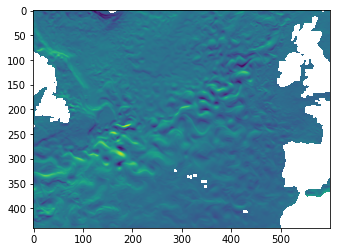

In [115]:
plt.imshow(u[0,::-1])

In [116]:
typenum=0

In [117]:
sigmavals=[1,2,4,8,16,32,64]
ns=len(sigmavals)
forcings=[]
for sigma in sigmavals:
    forcing1=eddy_forcing(uv, grid_data,sigma,nan_or_zero='nan',typenum=typenum).sel(yu_ocean=slice(-85, 85))\
                    .sel(xu_ocean=slice(xbeg,xter))
    forcings.append(forcing1)
    print(sigma)

1
2
4
8
16
32
64


In [118]:
varname=['u','v','T']
varname=['S'+v for v in varname]

units=['1e-7 m/$s^2$','1e-7 m/$s^2$','1e-7 m/$s^2$']


varname=['usurf','vsurf','surface_temp']+varname
units=['m/s','m/s','$^\circ$C']+units

varname_=varname.copy()
units_=units.copy()

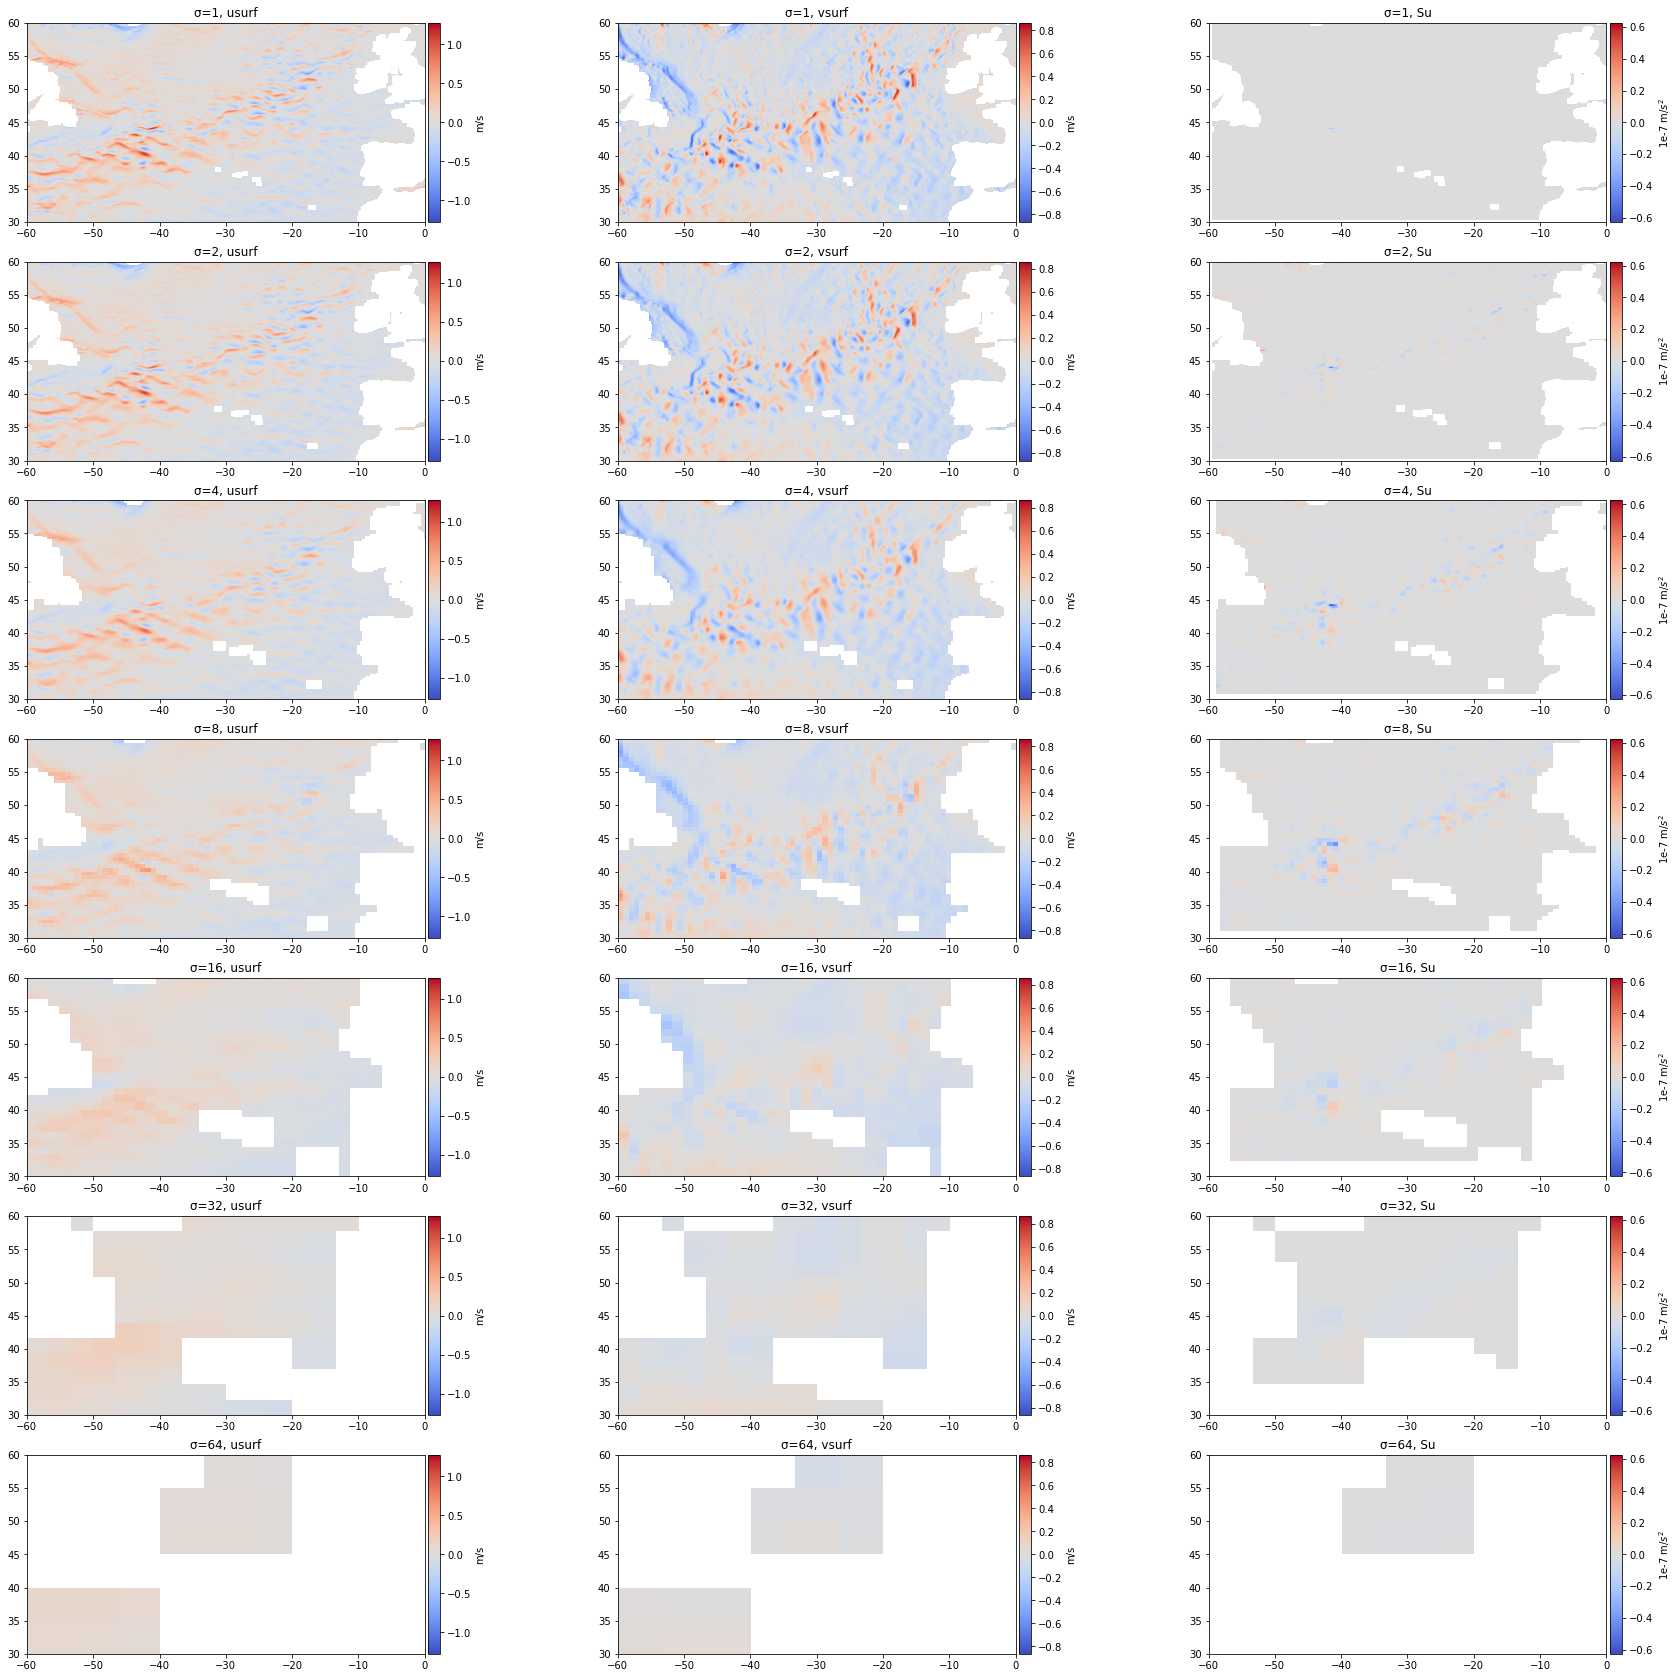

In [120]:


plot_var=[0,1,3]
varname=[varname_[i] for i in plot_var]
units=[units_[i] for i in plot_var]
nvar=len(varname)



#maximums=np.zeros((nvar,2))
maximums=np.zeros(nvar)
for j in range(nvar):
#     maximums[j,0]=-np.inf
#     maximums[j,1]=np.inf
    maximums[j]=0
    for i in range(ns):
        ff=forcings[i][varname[j]].values[0]
        #rs=np.sum(np.isnan(ff[-1]))
        #ff=ff[rs:,rs:]
        maximums[j]=np.maximum(np.amax(np.abs(ff[ff==ff])),maximums[j])
#         maximums[j,0]=np.maximum(np.amax(ff),maximums[j,0])
#         maximums[j,1]=np.minimum(np.amin(ff),maximums[j,1])



fig,axs=plt.subplots(ns,nvar,figsize=(30,30))
fig.patch.set_facecolor('white')
for i in range(ns):
    for j in range(nvar):
        ff=forcings[i][varname[j]].values[0]
        #rs=np.sum(np.isnan(ff[-1]))
        #ff=ff[rs:,rs:]
        ax=axs[i,j]
        neg=ax.imshow(ff[::-1],extent=[xmin,xmax,ymin,ymax]\
                                  ,cmap='coolwarm'\
                                  ,vmax=maximums[j],vmin=-maximums[j])
                                 #,vmax=maximums[j,0],vmin=maximums[j,1])
        ax.set_title('\u03C3='+str(sigmavals[i])+', '+varname[j])
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig.colorbar(neg,cax=cax)
        cbar.ax.set_ylabel(units[j])

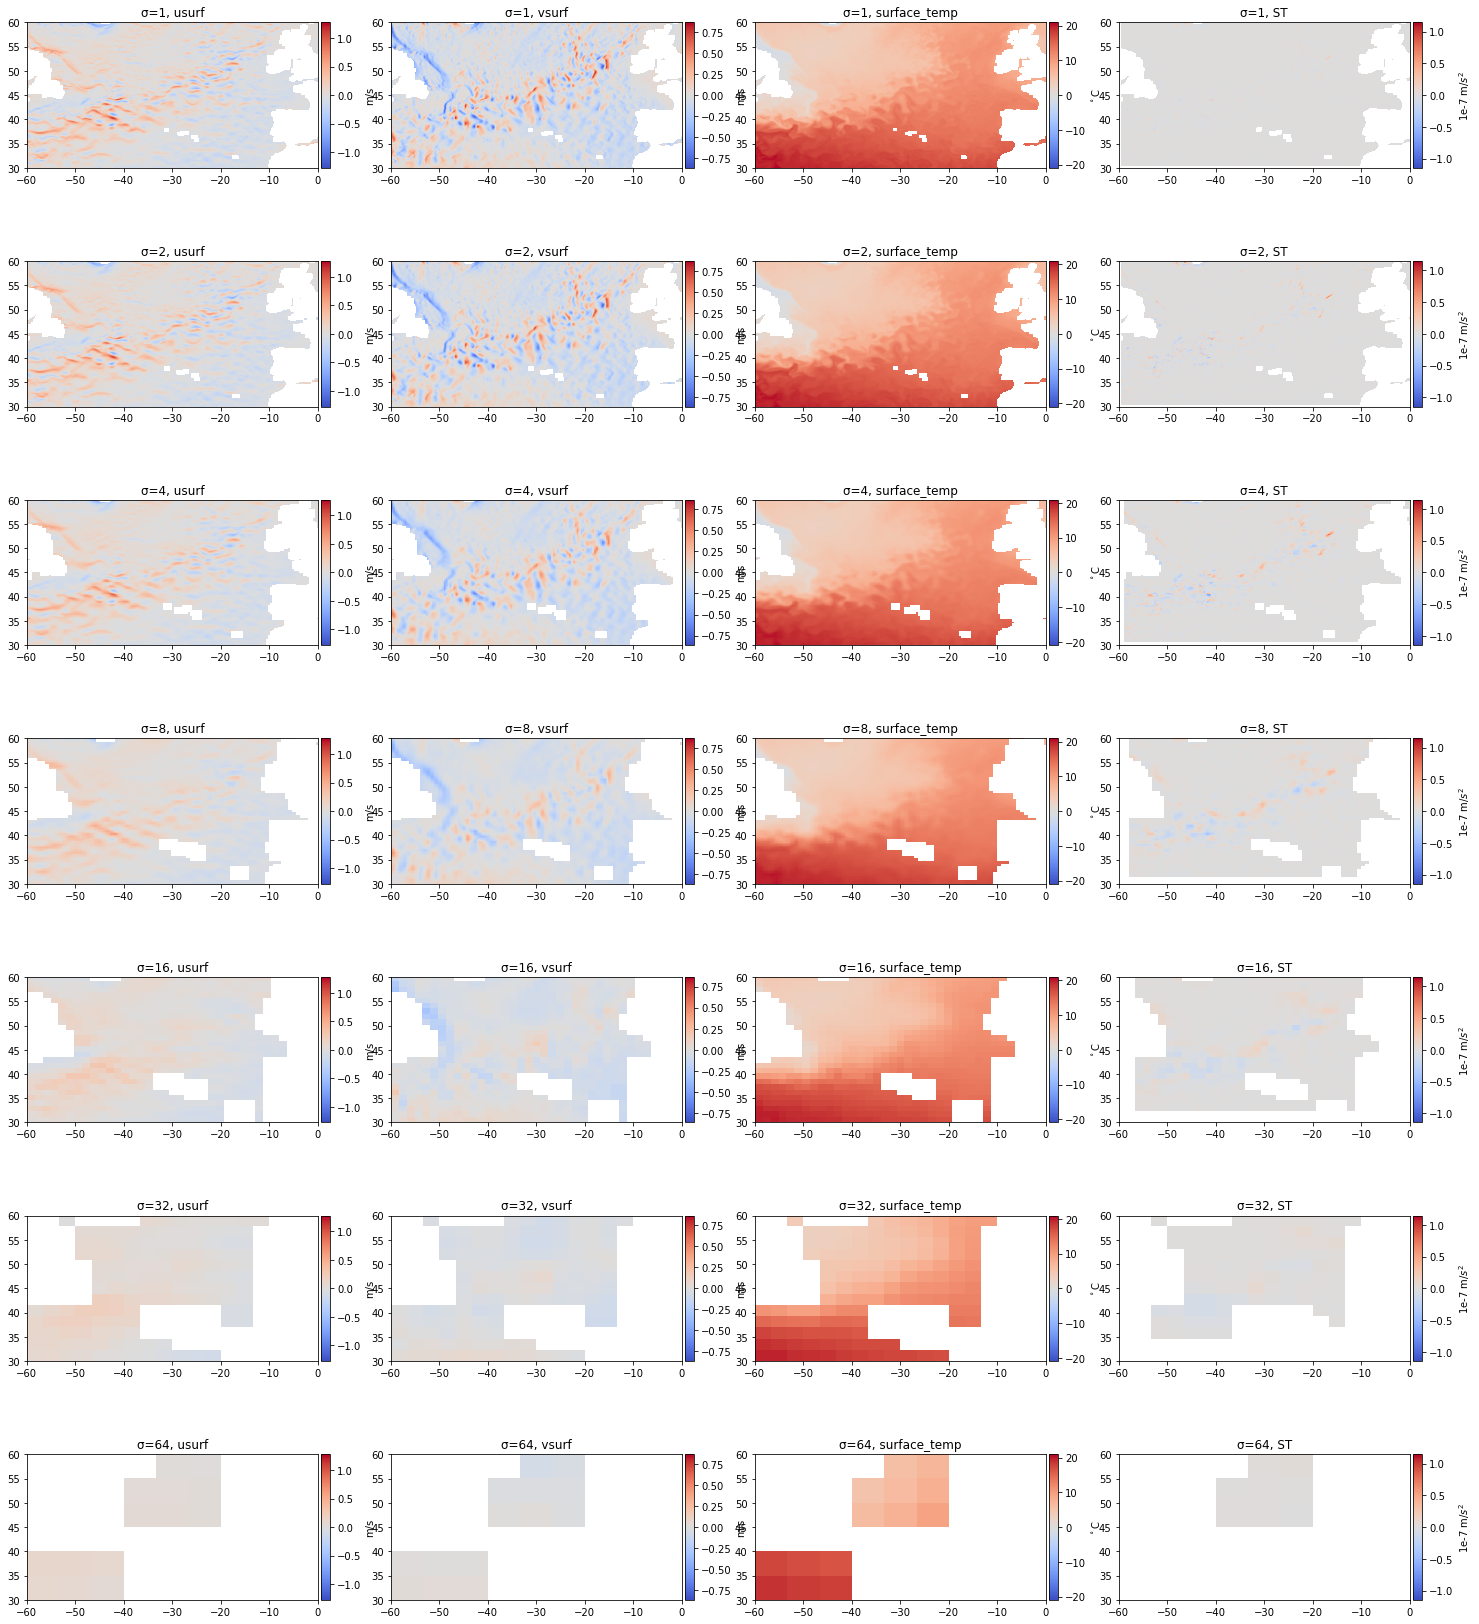

In [122]:
plot_var=[0,1,2,5]
varname=[varname_[i] for i in plot_var]
units=[units_[i] for i in plot_var]
nvar=len(varname)



#maximums=np.zeros((nvar,2))
maximums=np.zeros(nvar)
for j in range(nvar):
#     maximums[j,0]=-np.inf
#     maximums[j,1]=np.inf
    maximums[j]=0
    for i in range(ns):
        ff=forcings[i][varname[j]].values[0]
#         rs=np.sum(np.isnan(ff[-1]))
#         ff=ff[rs:,rs:]
        maximums[j]=np.maximum(np.amax(np.abs(ff[ff==ff])),maximums[j])
#         maximums[j,0]=np.maximum(np.amax(ff),maximums[j,0])
#         maximums[j,1]=np.minimum(np.amin(ff),maximums[j,1])



fig,axs=plt.subplots(ns,nvar,figsize=(25,30))
fig.patch.set_facecolor('white')
for i in range(ns):
    for j in range(nvar):
        ff=forcings[i][varname[j]].values[0]
#         rs=np.sum(np.isnan(ff[-1]))
#         ff=ff[rs:,rs:]
        ax=axs[i,j]
        neg=ax.imshow(ff[::-1],extent=[xmin,xmax,ymin,ymax]\
                                  ,cmap='coolwarm'\
                                  ,vmax=maximums[j],vmin=-maximums[j])
                                 #,vmax=maximums[j,0],vmin=maximums[j,1])
        ax.set_title('\u03C3='+str(sigmavals[i])+', '+varname[j])
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig.colorbar(neg,cax=cax)
        cbar.ax.set_ylabel(units[j])

In [41]:


TIME=500



u_v_dataset=xr.open_zarr(raw_data_address)\
                    .chunk(chunks={"time":1}).isel(time=np.arange(TIME,TIME+1))


u_v_dataset['xt_ocean']=u_v_dataset.xu_ocean.values
u_v_dataset['yt_ocean']=u_v_dataset.yu_ocean.values




x=u_v_dataset.xu_ocean.values
y=u_v_dataset.yu_ocean.values
dx=x[1]-x[0]
xbeg=x[0]
xter=x[-1]
#x=np.concatenate([dx*np.arange(-nb,0)+xbeg,x,dx*np.arange(1,nb+1)+xter],axis=0)
dx=x[1:]-x[:-1]
dy=y[1:]-y[:-1]

dx=np.reshape(dx,(1,-1))
dx=[dx for i in range(len(y)-1)]
dx=np.concatenate(dx,axis=0)
#dx=np.stack([dx],axis=0)

dy=np.reshape(dy,(-1,1))
dy=[dy for i in range(len(x)-1)]
dy=np.concatenate(dy,axis=1)
grid_data=xr.Dataset(data_vars=dict(dxu=(["yu_ocean","xu_ocean"],dx),\
                                    dyu=(["yu_ocean","xu_ocean"],dy)),\
                        coords=dict(xu_ocean=x[:-1],yu_ocean=y[:-1]))

In [24]:

u_v_datasetj=u_v_dataset#.isel(time=slice(jt,jt+1))
u=np.concatenate([u_v_datasetj.usurf.values,\
                            u_v_datasetj.vsurf.values,\
                              u_v_datasetj.surface_temp.values],axis=0)




uv=xr.Dataset(data_vars=dict(usurf=(["time","yu_ocean","xu_ocean"],u[0:1]),\
                                                vsurf=(["time","yu_ocean","xu_ocean"],u[1:2]),\
                                                 surface_temp=(["time","yu_ocean","xu_ocean"],u[2:3])),\
                                    coords=dict(xu_ocean=x,yu_ocean=y,time=np.arange(1)))

In [46]:
plot_var=np.arange(len(varname_))
varname=[varname_[i] for i in plot_var]
units=[units_[i] for i in plot_var]
nvar=len(varname)

In [47]:
r=3
sigmavals=[2**i for i in range(8)]

In [27]:
ns=len(sigmavals)
forcings=[]
for sigma in sigmavals:
    forcing1=eddy_forcing(uv, grid_data,sigma,nan_or_zero='nan',typenum=typenum).sel(yu_ocean=slice(-85, 85))\
                    .sel(xu_ocean=slice(xbeg,xter))
    forcings.append(forcing1)
    print(sigma)

1
2
4
8
16
32
64
128


In [28]:
energy=np.zeros((nvar,ns))
for j in range(nvar):
    for i in range(ns):
        ff=forcings[i][varname[j]].values[0]
        energy[j,i]=np.sqrt(np.mean(ff[ff==ff]**2))
        

In [32]:
forceeeee=forcings.copy()

In [44]:
forcings=forceeeee.copy()

Text(0.5, 1.0, 'Global Energy Averages')

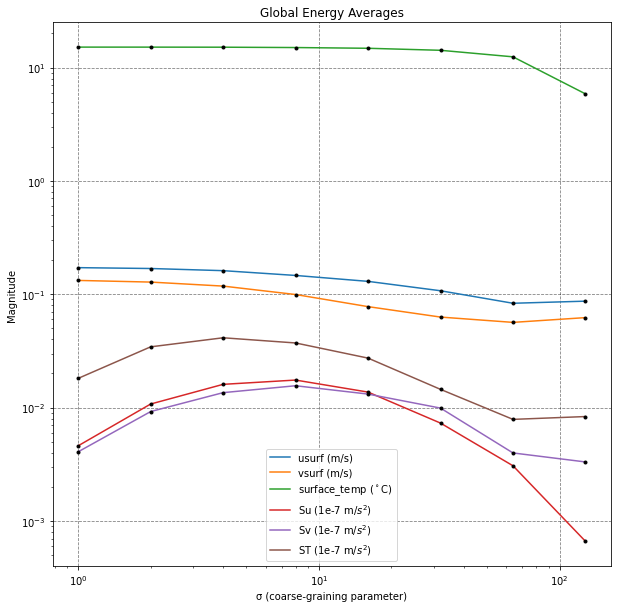

In [53]:
fig,axs=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('white')
ax=axs
for i in range(nvar):
    ax.loglog(sigmavals,energy[i],label=varname[i]+' ('+units[i]+')')
    ax.loglog(sigmavals,energy[i],'.k')

ax.legend()
ax.set_ylabel('Magnitude')
ax.set_xlabel('\u03C3 (coarse-graining parameter)')
ax.grid(color='k',linestyle='--',alpha=0.5)
ax.set_title('Global Energy Averages')